In [1]:
import sys
import os
maindir = os.getcwd()
sys.path.append(maindir+"/src")

In [2]:
# Load the data
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import skimage


from preprocessing import data_processing, compute_anomalies, extract_longitude_latitude, \
                            compute_forced_response, compute_variance, \
                            merge_runs,stack_runs, numpy_to_torch, standardize, build_training_and_test_sets

In [3]:
######################################## Extract data ###########################
############### Load climate model raw data for SST
with open('data/ssp585_time_series.pkl', 'rb') as f:
    data = pickle.load(f)


###################### Load longitude and latitude 
with open('data/lon.npy', 'rb') as f:
    lon = np.load(f)

with open('data/lat.npy', 'rb') as f:
    lat = np.load(f)

# define grid (+ croping for latitude > 60)
lat_grid, lon_grid = np.meshgrid(lat[lat<=60], lon, indexing='ij')

lat_size = lat_grid.shape[0]
lon_size = lon_grid.shape[1]
time_period=33

In [ ]:
data_processed, notnan_idx, nan_idx = data_processing(data, lon, lat,max_models=100)
x = compute_anomalies(data_processed, lon_size, lat_size, nan_idx, time_period=33)
y = compute_forced_response(data_processed, lon_size, lat_size, nan_idx, time_period=33)
vars = compute_variance(x, lon_size, lat_size, nan_idx, time_period=33)

# convert numpy arrays to pytorch 
x, y, vars = numpy_to_torch(x,y,vars)

# standardize data 
x, y = standardize(x,y,vars)

# merge runs for each model
# x_merged, y_merged, vars_merged = merge_runs(x,y,vars)

x, y, vars = stack_runs(x,y,vars,time_period,lon_size,lat_size)

/home/vcohen/cope/src/preprocessing.py:109: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp,axis=1)
/home/vcohen/cope/src/preprocessing.py:110: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(mean_ref_ensemble,axis=0)
/home/vcohen/cope/src/preprocessing.py:152: RuntimeWarning: Mean of empty slice
  mean_spatial_ensemble = np.nanmean(y_tmp,axis=0)
/home/vcohen/cope/src/preprocessing.py:156: RuntimeWarning: Mean of empty slice
  data_forced_response[m][r] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble,axis=0)


In [5]:
m0 = 'ICON-ESM-LR'
    
training_models, x_train, y_train, x_test, y_test = build_training_and_test_sets(m0,x,y,vars,lon_size,lat_size,time_period=33)

# 1- Ridge regression problem: 
# $\min_{W} \Vert Y - X W \Vert_F^2 + \lambda \Vert W \Vert_F^2$

In [6]:
def Ridge_regression_closed_form(X, Y, lambda_=1.0):
    """
    Computes the closed-form solution for reduced rank regression.
    
    Args:
        X (torch.Tensor): Predictor matrix of shape (n, p).
        Y (torch.Tensor): Response matrix of shape (n, q).
        lambda_ (scalar): Ridge penalty coefficient.
        
    Returns:
        U (torch.Tensor): Low-rank predictor coefficients of shape (p, rank).
        V (torch.Tensor): Low-rank response coefficients of shape (q, rank).
    """

    # compute Penroe Morose pseudo inverse of X^T @ X
    P = torch.linalg.inv(X.T @ X + lambda_ * torch.eye(X.shape[1]))
    
    # compute ordinary least square solution 
    W_ols = P @ X.T @ Y

    # print loss function
    loss = torch.norm(Y - X @ W_ols,p='fro')**2 + lambda_ * torch.norm(W_ols,p='fro')**2
    print("Loss function: ", loss.item())
    
    return W_ols

# 2- Ridge regression problem: 
# $\min_{W \colon \mathrm{rank}(W) \leq r} \Vert Y - X W \Vert_F^2 + \lambda \Vert W \Vert_F^2$

In [7]:
def RRR_closed_form(X, Y, rank=5.0, lambda_=1.0):
    """
    Computes the closed-form solution for reduced rank regression.
    
    Args:
        X (torch.Tensor): Predictor matrix of shape (n, p).
        Y (torch.Tensor): Response matrix of shape (n, q).
        rank (Int): Desired rank for the approximation.
        lambda_ (Float64): Ridge penalty coefficient.
        
    Returns:
        U (torch.Tensor): Low-rank predictor coefficients of shape (p, rank).
        V (torch.Tensor): Low-rank response coefficients of shape (q, rank).
    """

    # compute Penroe Morose pseudo inverse of X^T @ X
    P = torch.linalg.inv(X.T @ X + lambda_ * torch.eye(X.shape[1]))
    
    # compute ordinary least square solution 
    W_ols = P @ X.T @ Y
    
    # compute SVD decomposition of X @ W_ols
    U, S, Vh = torch.linalg.svd(X @ W_ols, full_matrices=False)
    
    # Truncate to the desired rank
    U_r = U[:, :rank]            # (p, rank)
    S_r = torch.diag(S[:rank])   # (rank, rank)
    V_r = Vh[:rank, :].T         # (q, rank)

    # compute regressor
    W_rrr = W_ols @ V_r @ V_r.T

    # print loss function
    loss = torch.norm(Y - X @ W_rrr,p='fro')**2 + lambda_ * torch.norm(W_rrr,p='fro')**2
    print("Loss function: ", loss.item())

    return W_rrr

In [9]:
# compute ridge regressor
W_ridge = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float32)
W_ridge[np.ix_(notnan_idx,notnan_idx)] = Ridge_regression_closed_form(x_train[:,notnan_idx], y_train[:,notnan_idx], lambda_=50.0)

# compute low rank ridge regressor
r = 70
W_rrr = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float32)
W_rrr[np.ix_(notnan_idx,notnan_idx)] = RRR_closed_form(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=50.0)

# compute low rank ridge regressor
r = 10
W_rrr = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float32)
W_rrr[np.ix_(notnan_idx,notnan_idx)] = RRR_closed_form(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=50.0)

# compute low rank ridge regressor
r = 5
W_rrr = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float32)
W_rrr[np.ix_(notnan_idx,notnan_idx)] = RRR_closed_form(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=50.0)

Loss function:  2852685.25
Loss function:  3147114.0
Loss function:  3756676.5
Loss function:  3951388.75


In [10]:
def prediction(x, W, notnan_idx,nan_idx):
    """
    Compute target prediction given time series x and regressor W.

    Args:
        - x: torch.tensor (time series length * nb_runs, grid size) 
        - W: torch.tensor (grid size non-nan idx, grid size non-nan idx)
        - notnan_idx, nan_idx: torch.tensor integers
    """
    
    y_pred = torch.zeros_like(x)
    
    y_pred = torch.nan_to_num(x).to(torch.float64) @ W.to(torch.float64)
    y_pred[:,nan_idx] = float('nan')
    
    return y_pred

LOO rmse ridge regression  0.6702623356335715
LOO rmse RRR (rank= 5 )   0.7066079483513836


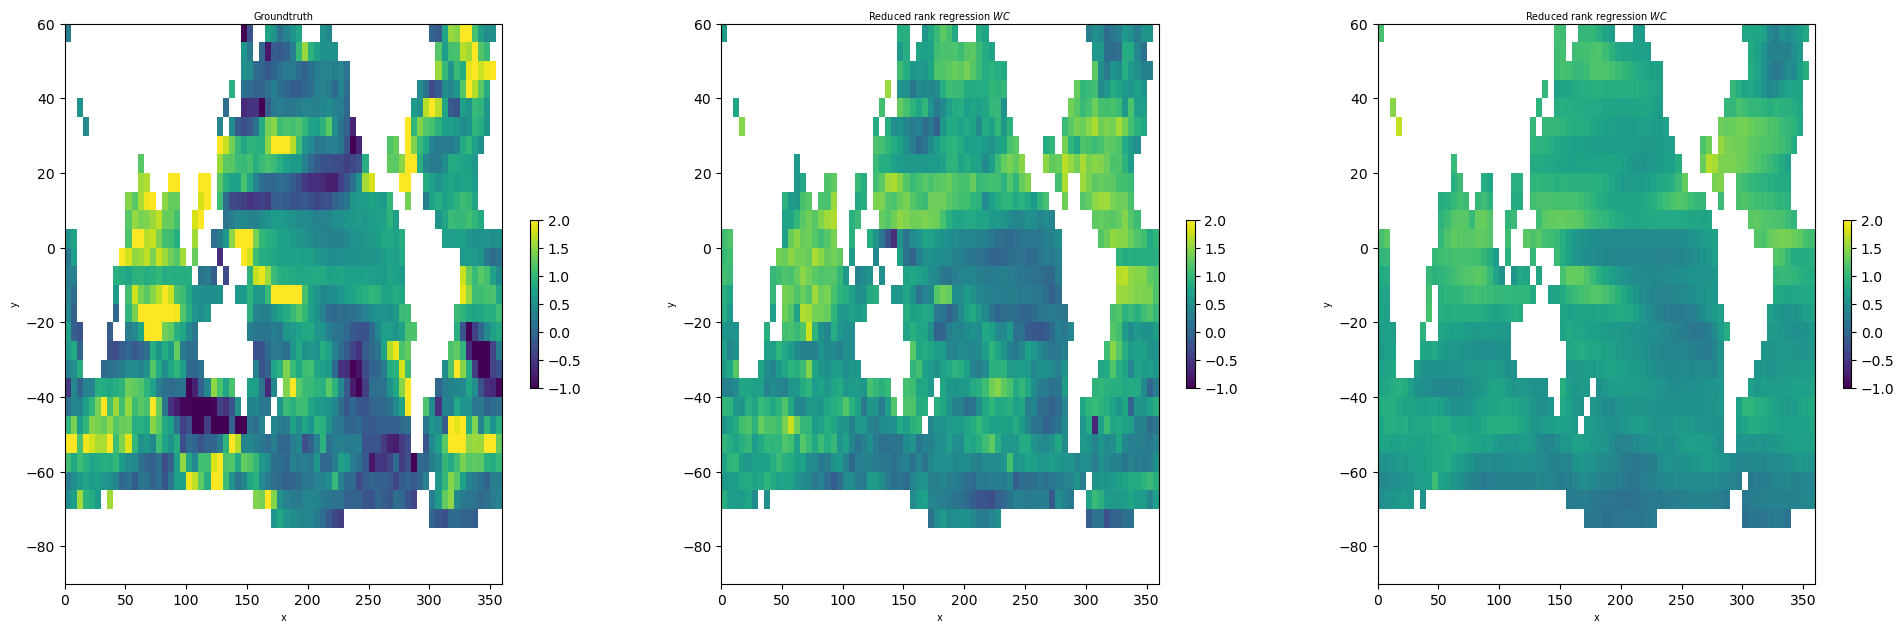

In [11]:
y_pred_ridge= prediction(x_test, W_ridge, notnan_idx, nan_idx)
y_pred_rrr = prediction(x_test, W_rrr, notnan_idx, nan_idx)

print("LOO rmse ridge regression ", torch.nanmean((y_pred_ridge - y_test)**2).item())
print("LOO rmse RRR (rank=",r,")  ", torch.nanmean((y_pred_rrr - y_test)**2).item())

y_target = y_test[:33,:]
y_target_pred_ridge = y_pred_ridge[:33,:]
y_target_pred_rrr = y_pred_rrr[:33,:]


# display Y map for a given model m0
time_idx = 20
y_target[:,nan_idx] = float('nan')
y_target_pred_ridge[:,nan_idx] = float('nan')
y_target_pred_rrr[:,nan_idx] = float('nan')

y_to_plot_target = y_target[time_idx,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred_ridge = y_target_pred_ridge[time_idx,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred_rrr = y_target_pred_rrr[time_idx,:].detach().numpy().reshape(lat_size,lon_size)


plt.close('all')
fig0 = plt.figure(figsize=(24,16))           

ax0 = fig0.add_subplot(2, 3, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax0 = fig0.add_subplot(2, 3, 2)        
ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_ridge,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax0 = fig0.add_subplot(2, 3, 3)        
ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_rrr,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

plt.show()

## Display predicted forced response for first run of left out climate model

In [12]:
from matplotlib import animation

time_period=33

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()


plt.close('all')
fig0 = plt.figure(figsize=(24,16))

ax0 = fig0.add_subplot(1, 3, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax1 = fig0.add_subplot(1, 3, 2)        
ax1.set_title(r'Ridge regression', size=7,pad=3.0)
ax1.set_xlabel(r'x', size=7)
ax1.set_ylabel(r'y', size=7)

ax2 = fig0.add_subplot(1, 3, 3)        
ax2.set_title(r'Low rank regression', size=7,pad=3.0)
ax2.set_xlabel(r'x', size=7)
ax2.set_ylabel(r'y', size=7)

y_to_plot_target = y_target[0,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred_rrr = y_target_pred_rrr[0,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred_ridge = y_target_pred_ridge[0,:].detach().numpy().reshape(lat_size,lon_size)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_ridge,vmin=-1.0,vmax=2.0)
im2 = ax2.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_rrr,vmin=-1.0,vmax=2.0)


def animate_maps(i):

    y_to_plot_target = y_target[i,:].detach().numpy().reshape(lat_size,lon_size)
    y_to_plot_pred_ridge = y_target_pred_ridge[i,:].detach().numpy().reshape(lat_size,lon_size)
    y_to_plot_pred_rrr = y_target_pred_rrr[i,:].detach().numpy().reshape(lat_size,lon_size)

    im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
    im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_ridge,vmin=-1.0,vmax=2.0)
    im2 = ax2.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_rrr,vmin=-1.0,vmax=2.0)
    
plt.colorbar(im0, ax=ax0, shrink=0.3)
plt.colorbar(im1, ax=ax1, shrink=0.3)
plt.colorbar(im2, ax=ax2, shrink=0.3)
animation.FuncAnimation(fig0, animate_maps, frames=time_period)

# Robust weight ridge regression

# $\max_{\alpha \in \Delta} \min_{W} \sum_{m} \alpha_m \Vert \Sigma^{-1/2}(Y_m - X_m W) \Vert_F^2 + \lambda \Vert W \Vert_F^2$

In [13]:
def low_rank_projection(w,rank=5):
    """Compute low rank projection.

        Args:

        Returns:
    """

    # compute SVD decomposition of W
    U, S, Vh = torch.linalg.svd(w.to(torch.float64), full_matrices=False)
    
    # Truncate to the desired rank
    U_r = U[:, :rank]            # (p, rank)
    S_r = torch.diag(S[:rank])   # (rank, rank)
    V_r = Vh[:rank, :].T         # (q, rank)

    # compute regressor
    w_low_rank = U_r @ S_r @ V_r.T 

    return w_low_rank

### Compute gradient with respect to $W$

In [25]:
def compute_gradient(models,x,y,w,notnan_idx,lambda_=1.0,mu_=1.0):
    """This function computes the gradient of ridge log-sum-exp loss with respect to W.

    Args:
        
    Returns:
        - Gradient matrix: torch.tensor d x d
    """
    res = torch.zeros(len(models), w.shape[0], w.shape[0]).to(torch.float64)
    res_sumexp = torch.zeros(len(models)).to(torch.float64)

    for idx_m, m in enumerate(models):
        
        
        # compute -2X_{m,r}^T (Y_{m,r}^T - X_{m,r}^T W)
        res[idx_m][np.ix_(notnan_idx,notnan_idx)] = - 2*torch.mean(torch.bmm(torch.transpose(x[m][:,:,notnan_idx], 1,2) , \
                                                        y[m][:,:,notnan_idx] - x[m][:,:,notnan_idx] @ w[np.ix_(notnan_idx,notnan_idx)]),dim=0)
        

        # compute the exponential term
        res_sumexp[idx_m] = (1/mu_)*torch.mean(torch.norm(y[m][:,:,notnan_idx] - x[m][:,:,notnan_idx] @ w[np.ix_(notnan_idx,notnan_idx)],p='fro',dim=(1,2))**2)
     
    
    softmax = torch.nn.Softmax(dim=0)
    res_sumexp = softmax(res_sumexp)
    
    # compute gradient as sum (res * softmax)
    grad = torch.sum(torch.unsqueeze(torch.unsqueeze(res_sumexp,-1),-1) * res, dim=0)
    grad[np.ix_(notnan_idx,notnan_idx)] = grad[np.ix_(notnan_idx,notnan_idx)] + 2*lambda_* w[np.ix_(notnan_idx,notnan_idx)]
    
    return grad 

### Gradient descent algorithm

In [27]:
def train_robust_weights_model(models,x,y,lon_size,lat_size,notnan_idx,rank=5.0,lambda_=1.0,mu_=1.0,lr=0.1,nb_iterations=10):
    """This function computes the gradient of ridge log-sum-exp loss with respect to W.

       Args:
            
       Returns:
    """
    w = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)
    w_old = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)

    training_loss = torch.zeros(nb_iterations)
    
    # run a simple loop
    for it in range(nb_iterations):


        # accelerate gradient descent
        if it > 1:
            w_tmp = w + ((it-1)/(it+2)) * (w - w_old)
        else:
            w_tmp = w.detach()

        # save old parameter
        w_old = w.clone().detach()

        # print("Gradient computation")
        # start_time = time.time()
        # compute gradient
        grad = compute_gradient(models,x,y,w_tmp,notnan_idx,lambda_,mu_)
        # print("--- %s seconds ---" % (time.time() - start_time)) 


        # update the variable w
        w = w_tmp - lr * grad

        # low rank projection
        if rank is not None:
            w = low_rank_projection(w,rank=rank)


        # # compute loss functon to check convergence 
        # res = torch.zeros(len(models))

        # for idx_m, m in enumerate(models):

        #     # compute residuals
        #     res[idx_m] = torch.mean(torch.norm(y[m][:,:,notnan_idx] -x[m][:,:,notnan_idx] @ w[notnan_idx,:][:,notnan_idx], p='fro',dim=(1,2))**2)
    
        # obj = mu_*torch.logsumexp((1/mu_)* res,0)
        # obj += lambda_*torch.norm(w,p='fro')**2
        
        # training_loss[it] = obj.item()

        # print("Iteration: ", it, " Loss: ", obj.item())
        

    # plt.close('all')
    # plt.figure()
    # plt.plot(range(nb_iterations),training_loss)
    # plt.title('Training loss')
    # plt.ylabel('Loss')
    # plt.xlabel('Iterations')
    # plt.show()
    
    return w, training_loss

In [29]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# x = { key: elt.to(device) for (key, elt) in x.items()}
# y = { key: elt.to(device) for (key, elt) in y.items()} 


# convert all data to pytorch tensors with precision float32
x = {key: elt.to(torch.float64) for key, elt in x.items()}
y = {key: elt.to(torch.float64) for key, elt in y.items()}
vars = {key: elt.to(torch.float64) for key, elt in vars.items()}

In [30]:
lambda_tmp = 100.0
mu_tmp = 1000.0

import time
start_time = time.time()

w_robust_ridge, training_loss = train_robust_weights_model(training_models,x,y,\
                                                           lon_size,lat_size,notnan_idx,rank=10,\
                                                           lambda_=lambda_tmp,mu_=mu_tmp,lr=1e-5,nb_iterations=20)
print("--- %s seconds ---" % (time.time() - start_time)) 

--- 92.78178286552429 seconds ---


### Compute weights given matrix W

In [86]:
# function to compute weights
def compute_weights(models,w,x,y,notnan_idx,lambda_=1.0,mu_=1.0):
    """Compute weights of models given regressor matrix W.
        
        Args:

        Returns:
    """
   
    M = len(list(models))
    alpha = torch.zeros(M)
    res = torch.zeros(M)
    
    for idx_m,m in enumerate(models):
        
        res[idx_m] = torch.mean(torch.norm(y[m][:,:,notnan_idx] - x[m][:,:,notnan_idx] @ w[notnan_idx,:][:,notnan_idx], p='fro',dim=(1,2))**2)
        alpha[idx_m] = (1/mu_)*res[idx_m]

    # softmax function to compute weights $\alpha$
    alpha = torch.nn.functional.softmax(alpha)
    weights = {m: alpha[idx_m].item() for idx_m,m in enumerate(models)}

    return weights

In [87]:
# y_pred = torch.ones_like(x_test).to(torch.float64)
# y_pred[:,nan_idx] = float('nan')
# y_pred[:,notnan_idx] = x_test[:,notnan_idx].to(torch.float64) @ w_robust_ridge[notnan_idx,:][:,notnan_idx].to(torch.float64)

# y_target = y_test[:33,:]
# y_target_pred = y_pred[:33,:]


# # display Y map for a given model m0
# time_idx = 20
# y_target[:,nan_idx] = float('nan')
# y_target_pred[:,nan_idx] = float('nan')

# y_to_plot_target = y_target[time_idx,:].detach().numpy().reshape(lat_size,lon_size)
# y_to_plot_pred = y_target_pred[time_idx,:].detach().numpy().reshape(lat_size,lon_size)

# print("RMSE : ", torch.nanmean((y_test - y_pred)**2))

def plot_gt_vs_pred(y_truth,x, w, notnan_idx, nan_idx,lon_grid, lat_grid, time_idx=10):

    """
    Plot groundtruth vs prediction for a given time index.

    Args:


    No returns.
    """

    # compute prediction given x and w.
    y_pred = prediction(x, w, notnan_idx, nan_idx)

    # capture grid size
    lat_size = lat_grid.shape[0]
    lon_size = lon_grid.shape[1]

    # define tensor to plot (for the first run)
    y_to_plot_target = y_truth[time_idx,:].detach().numpy().reshape(lat_size,lon_size)
    y_to_plot_pred = y_pred[time_idx,:].detach().numpy().reshape(lat_size,lon_size)

    # reset figures to plot
    plt.close('all')
    
    fig0 = plt.figure(figsize=(24,16))           

    ax0 = fig0.add_subplot(2, 2, 1)        
    ax0.set_title(r'Groundtruth', size=7,pad=3.0)
    im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
    plt.colorbar(im0, ax=ax0, shrink=0.3)
    ax0.set_xlabel(r'x', size=7)
    ax0.set_ylabel(r'y', size=7)
    
    ax0 = fig0.add_subplot(2, 2, 2)        
    ax0.set_title(r'Predictions', size=7,pad=3.0)
    im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)
    plt.colorbar(im0, ax=ax0, shrink=0.3)
    ax0.set_xlabel(r'x', size=7)
    ax0.set_ylabel(r'y', size=7)

    plt.show()

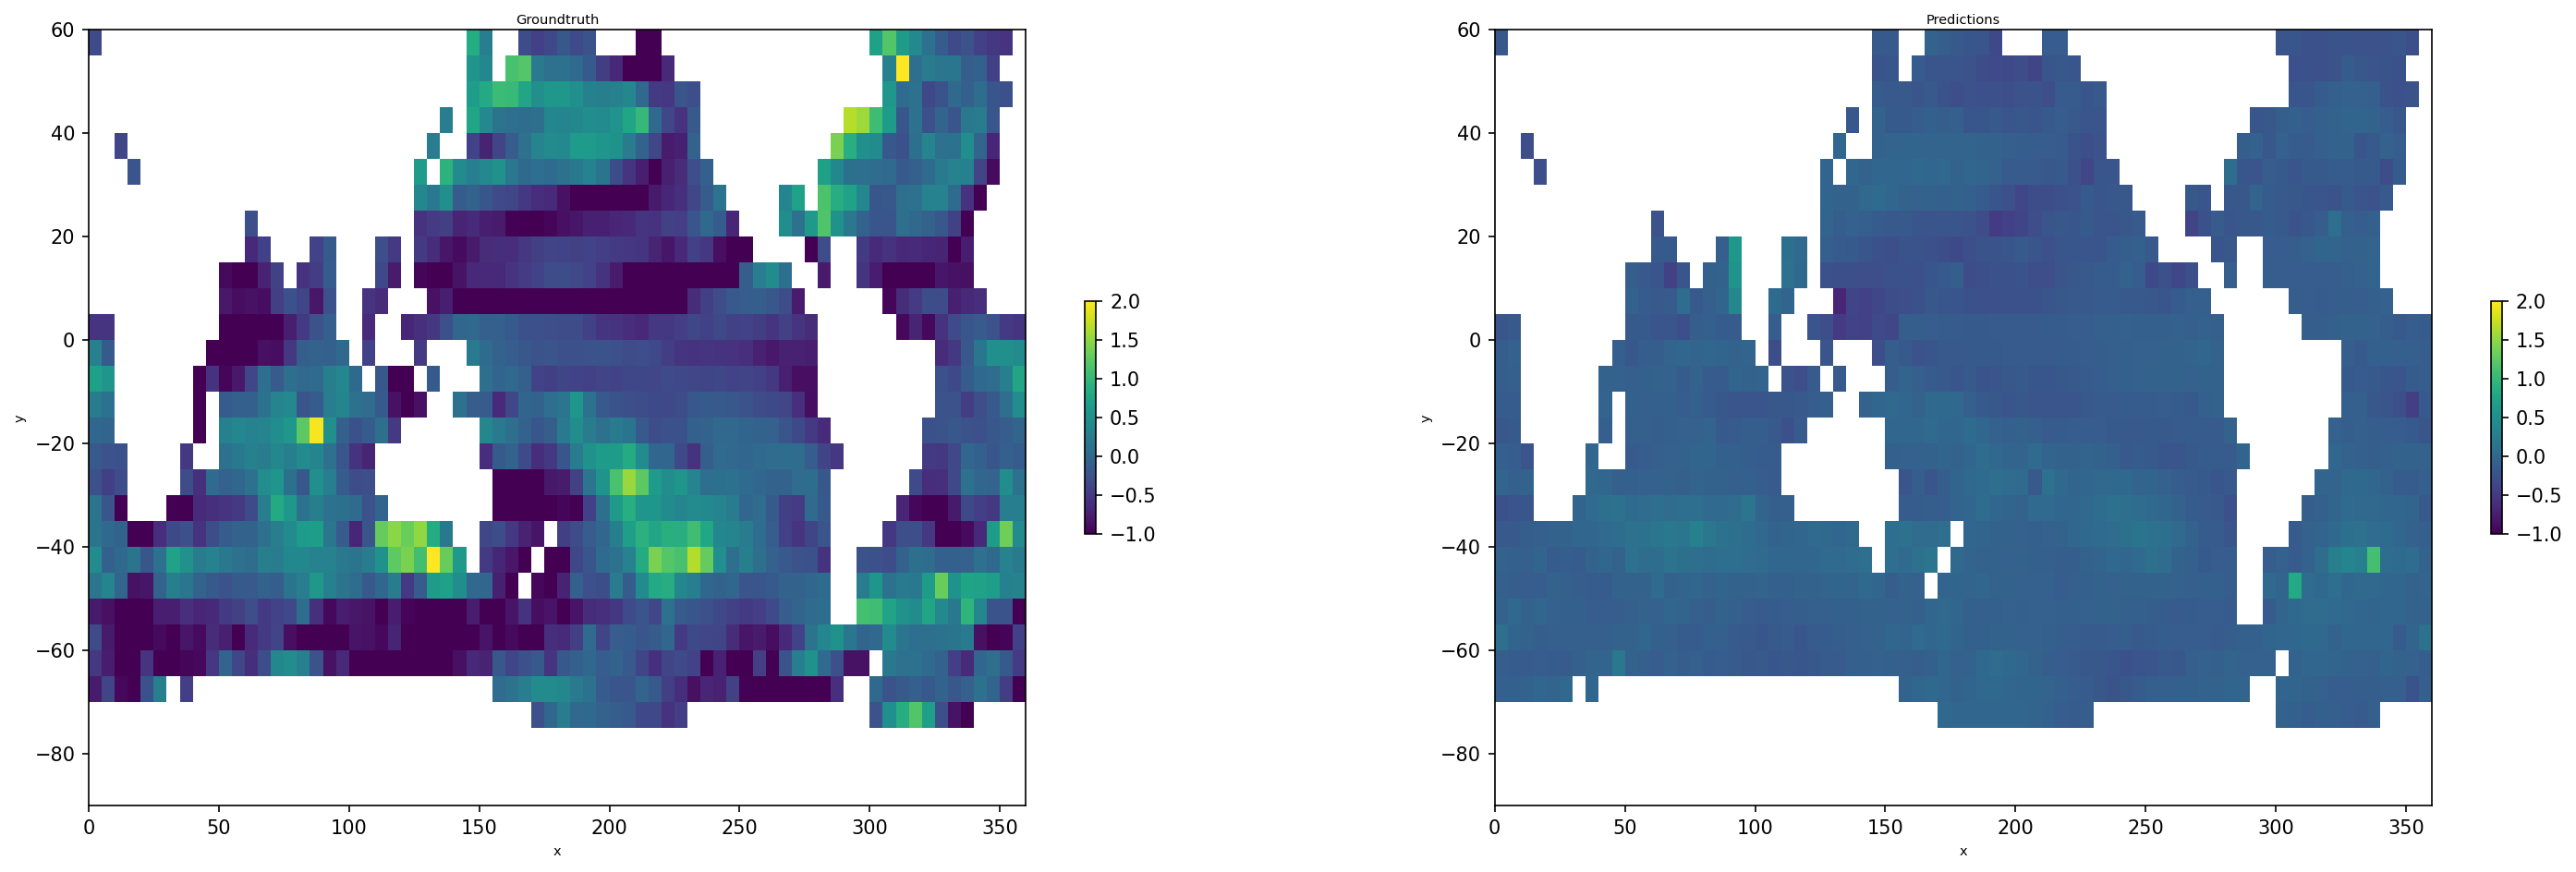

In [88]:
plot_gt_vs_pred(y_test,x_test,w_robust_ridge, notnan_idx, nan_idx,lon_grid, lat_grid, time_idx=10)

In [89]:
# from matplotlib import animation

# plt.rcParams["animation.html"] = "jshtml"
# plt.rcParams['figure.dpi'] = 150  
# plt.ioff()


# plt.close('all')
# fig0 = plt.figure(figsize=(24,16))

# ax0 = fig0.add_subplot(1, 2, 1)        
# ax0.set_title(r'Groundtruth', size=7,pad=3.0)
# ax0.set_xlabel(r'x', size=7)
# ax0.set_ylabel(r'y', size=7)

# ax1 = fig0.add_subplot(1, 2, 2)        
# ax1.set_title(r'Robust reduced rank regression ', size=7,pad=3.0)
# ax1.set_xlabel(r'x', size=7)
# ax1.set_ylabel(r'y', size=7)

# y_to_plot_target = y_target[0,:].detach().numpy().reshape(lat_size,lon_size)
# y_to_plot_pred = y_target_pred[0,:].detach().numpy().reshape(lat_size,lon_size)
# im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
# im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)


# def animate_maps(i):

#     y_to_plot_target = y_target[i,:].detach().numpy().reshape(lat_size,lon_size)
#     y_to_plot_pred = y_target_pred[i,:].detach().numpy().reshape(lat_size,lon_size)

#     im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
#     im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)
    
# plt.colorbar(im0, ax=ax0, shrink=0.3)
# plt.colorbar(im1, ax=ax1, shrink=0.3)
# plt.tight_layout()
# animation.FuncAnimation(fig0, animate_maps, frames=time_period)

In [90]:
# plt.close('all')

# # plot the model contributions
# fig, ax = plt.subplots()
# models = training_models
# weights_plot = list(weights.values())

# ax.bar(training_models, weights_plot,label='Model weights')
# ax.set_ylabel(r'weights $\gamma$')
# ax.set_ylim(0.0,1.0)
# ax.set_title('cmip6 models')
# ax.legend()
# ax.set_xticklabels(models, rotation=-90)
# plt.tight_layout()
# plt.show()

# Leave-one-out procedure

In [91]:
def leave_one_out_single(model_out,x,y,vars,\
                         lon_size,lat_size,notnan_idx,time_period=33,\
                         method='ridge',rank=5,lambda_=1.0,mu_=1.0,\
                         lr=1e-5,nb_gradient_iterations=50,\
                         verbose=True):
    """Run a single iteration the leave-one-out procedure (LOO) with model_out out of the training set.

        Args:

        Returns:
    """
    W = torch.zeros(lon_size * lat_size, lon_size * lat_size).to(torch.float64)
    training_models, x_train, y_train, x_test, y_test = build_training_and_test_sets(model_out,x,y,vars,lon_size,lat_size,time_period=33)
    
    
    # if method = ridge, then we train the ridge regression model
    if method == 'ridge':

        # compute ridge regression coefficient 
        W[np.ix_(notnan_idx,notnan_idx)] = Ridge_regression_closed_form(x_train[:,notnan_idx], y_train[:,notnan_idx], lambda_)

    elif method == 'rrr':

        # compute low rank ridge regression coefficient
        W[np.ix_(notnan_idx,notnan_idx)] = RRR_closed_form(x_train[:,notnan_idx], y_train[:,notnan_idx], rank, lambda_)

    elif method == 'robust':

        # compute low rank ridge regression coefficient
        W, training_loss  = train_robust_weights_model(training_models,x,y,lon_size,lat_size,\
                                                       notnan_idx,rank,lambda_,mu_,lr,nb_iterations=nb_gradient_iterations)
                                                    
    
    # Predictions on test set       
    y_pred = torch.ones_like(x_test).to(torch.float64)
    y_pred[:,nan_idx] = float('nan')
    y_pred[:,notnan_idx] = x_test[:,notnan_idx].to(torch.float64) @ W[np.ix_(notnan_idx,notnan_idx)].to(torch.float64)

    # Compute training errors
    y_pred_train = {}
    rmse_train = {}

    # Compute training errors
    y_pred_train = {}
    rmse_train = {}

    for idx_m,m in enumerate(x.keys()):
        
        if m != model_out:

            y_pred_train[m] = torch.zeros(x[m].shape[0],time_period,lon_size*lat_size).to(torch.float64)
            y_pred_train[m][:,:,notnan_idx] =  x[m][:,:,notnan_idx] @ W[np.ix_(notnan_idx,notnan_idx)].to(torch.float64)
            rmse_train[m] = torch.nanmean((y_pred_train[m] - y[m])**2)

    # compute the weights
    if method == "robust":
        weights = compute_weights(training_models,W,x,y,notnan_idx,lambda_,mu_)
    else:
        weights = (1/len(training_models)) * torch.ones(len(training_models))
    
    return W, y_pred, y_test, rmse_train

In [92]:
%prun W_robust, y_pred, y_test, rmse_train = leave_one_out_single(m0,x,y,vars,\
                                                              lon_size,lat_size,notnan_idx,time_period=33,\
                                                              method='robust',rank=None, lambda_=100.0, mu_=1000.0,\
                                                              lr=1e-5,nb_gradient_iterations=20,\
                                                              verbose=True)

Iteration:  0  Loss:  68391.625
Iteration:  1  Loss:  54988.421875
Iteration:  2  Loss:  52712.97265625
Iteration:  3  Loss:  49781.0859375
Iteration:  4  Loss:  46349.01171875
Iteration:  5  Loss:  43870.28125
Iteration:  6  Loss:  41659.84765625
Iteration:  7  Loss:  39652.24609375
Iteration:  8  Loss:  37642.99609375
Iteration:  9  Loss:  35850.19140625
Iteration:  10  Loss:  34154.91796875
Iteration:  11  Loss:  32612.830078125
Iteration:  12  Loss:  31237.759765625
Iteration:  13  Loss:  30077.927734375
Iteration:  14  Loss:  29147.384765625
Iteration:  15  Loss:  28404.099609375
Iteration:  16  Loss:  27783.14453125
Iteration:  17  Loss:  27237.0
Iteration:  18  Loss:  26740.0
Iteration:  19  Loss:  26280.2578125
 

/tmp/ipykernel_11011/513617020.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = torch.nn.functional.softmax(alpha)


         67932 function calls (67912 primitive calls) in 73.212 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       20   29.553    1.478   56.098    2.805 466472026.py:1(compute_gradient)
        1   13.794   13.794   70.350   70.350 773321312.py:1(train_robust_weights_model)
      660   12.948    0.020   12.948    0.020 {built-in method torch.bmm}
     2013    9.712    0.005    9.712    0.005 {built-in method torch.mean}
      112    1.437    0.013    1.437    0.013 {method 'to' of 'torch._C.TensorBase' objects}
       64    1.397    0.022    1.397    0.022 {built-in method torch.cat}
       20    0.857    0.043    0.857    0.043 {built-in method torch.sum}
       99    0.673    0.007    0.673    0.007 {built-in method torch.zeros}
        1    0.672    0.672    0.682    0.682 513617020.py:2(compute_weights)
        1    0.626    0.626   73.211   73.211 3225616153.py:1(leave_one_out_single)
     4148    0.597    0.000  

In [93]:
# weights = compute_weights(training_models,W_robust,x,y,notnan_idx,lambda_=100.0,mu_=1000.0)

# print(np.sum(list(weights.values())))

# plt.close('all')

# # plot the model contributions
# fig, ax = plt.subplots()
# models = training_models
# weights_plot = list(weights.values())

# ax.bar(training_models, weights_plot,label='Model weights')
# ax.set_ylabel(r'weights $\gamma$')
# ax.set_ylim(0.0,1.0)
# ax.set_title('cmip6 models')
# ax.legend()
# ax.set_xticklabels(models, rotation=-90)
# plt.tight_layout()
# plt.show()

In [94]:
def leave_one_out_procedure(x,y,vars,\
                            lon_size,lat_size, notnan_idx,time_period=33,\
                            method='ridge',rank=None,lambda_=1.0,mu_=1.0,\
                            lr=1e-5,nb_gradient_iterations=20,verbose=True):
    """It runs the LOO procedure.

    """
    W = {}
    y_pred = {}
    y_test = {}
    
    rmse_mean = {}
    
    weights = {m: 0.0 for idx_m, m in enumerate(x.keys())}
    training_loss = {m: {} for idx_m, m in enumerate(x.keys())}
    
    for idx_m, m in enumerate(x.keys()):

        # run leave one out
        W[m], y_pred[m], y_test[m], training_loss[m] = leave_one_out_single(m,x,y,vars,\
                                                                            lon_size,lat_size,notnan_idx,time_period,\
                                                                            method,rank,lambda_,mu_,\
                                                                            lr,nb_gradient_iterations,verbose)
                                                  
        
        # compute mean rmse 
        rmse_mean[m] = torch.nanmean((y_pred[m] - y_test[m])**2)        
    
        # print the rmse
        print('RMSE (mean) on model ', m, ' : ', rmse_mean[m].item())

        # list of training models
        models_tmp = list(training_loss[m].keys())

        if method == 'robust':

            # compute robust model weights
            weights[m] = compute_weights(models_tmp,W[m],x,y,notnan_idx,lambda_,mu_)

        else:

            # if we do not use the robust weight approach, then we compute uniform weights
            weights[m] = {m_tmp: 1/len(models_tmp) for m_tmp in models_tmp}
            
        # compute weight = 0.0 for climate model m 
        weights[m][m] = 0.0

    weights_tmp = torch.zeros(len(x.keys()))
    for idx_m, m in enumerate(x.keys()):
        weights_tmp +=  torch.tensor(list(weights[m].values()))

    weights_tmp = weights_tmp / (len(x.keys()))

    # Check that the sum of weights = 1
    print("Check that sum of weights ==1 : ", torch.sum(weights_tmp).item())
    
    # update the list of model to take into account
    models = list(x.keys()) 
    
    ################# plot the rmse #################
    fig, ax = plt.subplots()
    ax.bar(models, weights_tmp,label='Model weights')
    ax.set_ylabel(r'$\alpha^m$')
    ax.legend()
    ax.set_xticklabels(models, rotation=-90)
    plt.tight_layout()
    # plt.savefig("results/weights_"+str(mu_)+"_"+str(lambda_)+".eps", dpi=150)
    plt.show()
    
    ################# plot the rmse #################
    fig, ax = plt.subplots()
    rmse_plot = list(rmse_mean.values()) 
    ax.bar(models, rmse_plot,label='rmse')
    ax.set_ylabel(r'LOO')
    ax.set_title('LOO rmse')
    ax.legend()
    ax.set_xticklabels(models, rotation=-90)
    plt.tight_layout()
    # plt.savefig("results/rmse_"+method+"_"+str(mu_)+"_"+str(lambda_)+".eps", dpi=150)
    plt.show()
    

    return W, rmse_mean, training_loss, weights

Loss function:  2909511.210718692
RMSE (mean) on model  ICON-ESM-LR  :  0.6552789055113322
Loss function:  2891167.2910276568
RMSE (mean) on model  EC-Earth3  :  0.11117046769788887
Loss function:  2891738.684217172
RMSE (mean) on model  CMCC-CM2-SR5  :  0.2387654258946064
Loss function:  2904019.476106005
RMSE (mean) on model  ACCESS-CM2  :  0.22845238321421737
Loss function:  2911960.527070364
RMSE (mean) on model  CESM2  :  0.1808542621767404
Loss function:  2923367.1407114
RMSE (mean) on model  CNRM-ESM2-1  :  0.1506110644014738
Loss function:  2875500.170373111
RMSE (mean) on model  IPSL-CM6A-LR  :  0.09092662708885316
Loss function:  2891772.94435619
RMSE (mean) on model  GISS-E2-2-G  :  0.2457792451631352
Loss function:  2889011.7723726323
RMSE (mean) on model  CNRM-CM6-1  :  0.08617400000333675
Loss function:  2794257.413800889
RMSE (mean) on model  CanESM5-1  :  0.09159550905464255
Loss function:  2898820.349440026
RMSE (mean) on model  E3SM-2-0-NARRM  :  1.1139187574194198
Lo

/tmp/ipykernel_11011/3144833690.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)


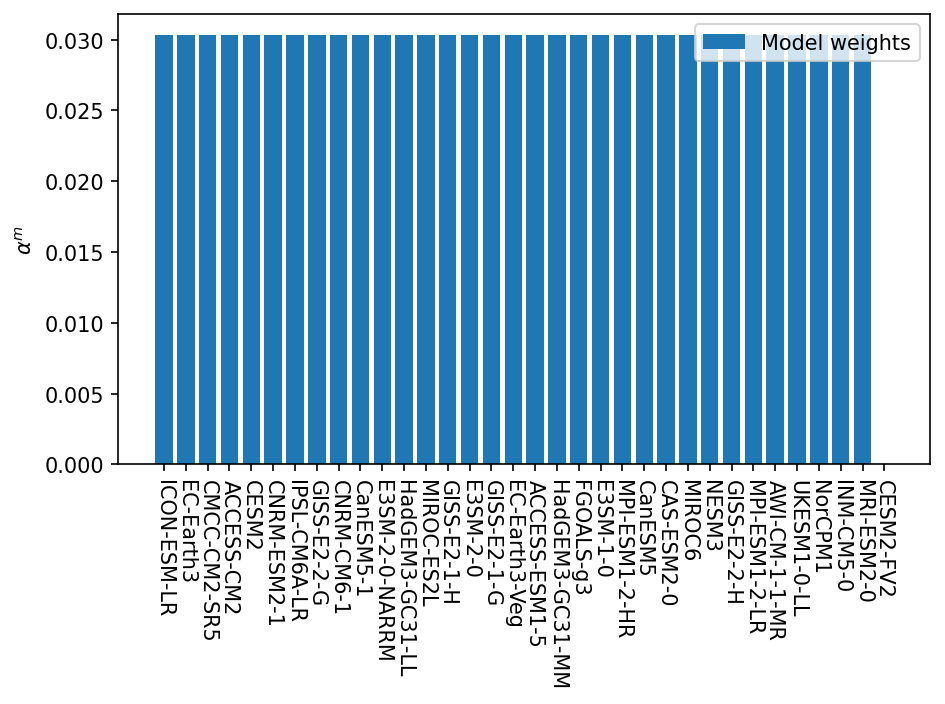

/tmp/ipykernel_11011/3144833690.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)


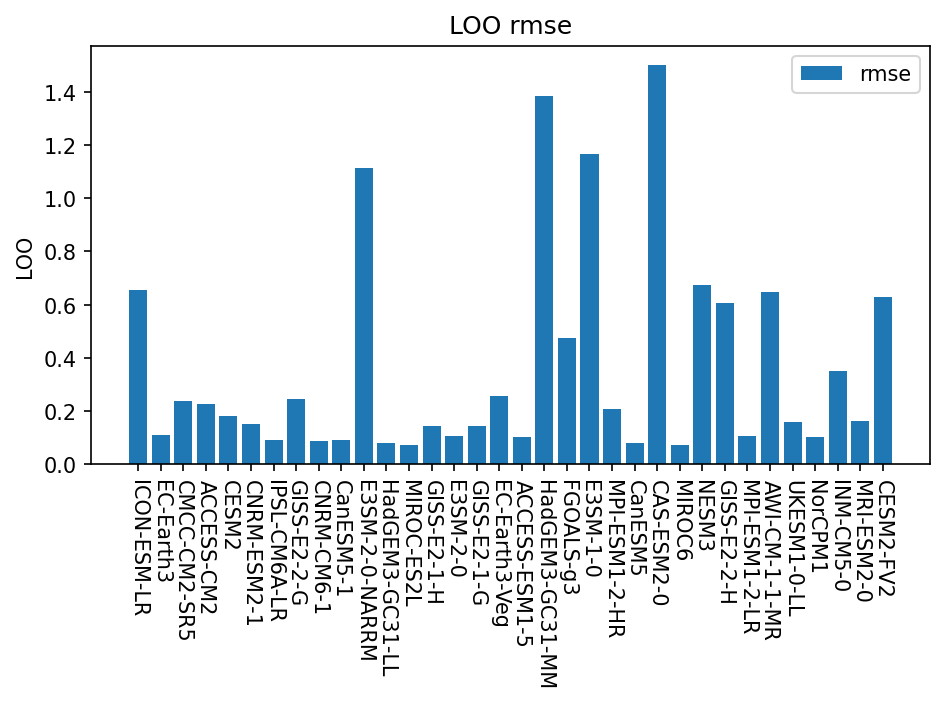

In [95]:
plt.close("all")

lambda_tmp = 100.0
mu_tmp = 1000.0
rank_tmp = 10

W_ridge, rmse_mean_ridge, training_loss_ridge, weights_ridge = leave_one_out_procedure(x,y,vars,\
                                                                                    lon_size,lat_size, notnan_idx,time_period=33,\
                                                                                    method='ridge',rank=None,lambda_=lambda_tmp,mu_=mu_tmp,\
                                                                                    lr=1e-5,nb_gradient_iterations=50,verbose=True)

Loss function:  3791471.5788017926
RMSE (mean) on model  ICON-ESM-LR  :  0.691705553982246
Loss function:  3822842.365849495
RMSE (mean) on model  EC-Earth3  :  0.10960340408505564
Loss function:  3810694.2194920247
RMSE (mean) on model  CMCC-CM2-SR5  :  0.2525504940824503
Loss function:  3830472.636974249
RMSE (mean) on model  ACCESS-CM2  :  0.22993033084464598
Loss function:  3838090.8923374848
RMSE (mean) on model  CESM2  :  0.18891817721498175
Loss function:  3852482.193918969
RMSE (mean) on model  CNRM-ESM2-1  :  0.15309823179075457
Loss function:  3810377.1293850443
RMSE (mean) on model  IPSL-CM6A-LR  :  0.08528618750341692
Loss function:  3820833.577735493
RMSE (mean) on model  GISS-E2-2-G  :  0.25026171970955835
Loss function:  3827787.0898267035
RMSE (mean) on model  CNRM-CM6-1  :  0.07925463947940295
Loss function:  3750719.256762825
RMSE (mean) on model  CanESM5-1  :  0.07990671715570563
Loss function:  3737824.909100485
RMSE (mean) on model  E3SM-2-0-NARRM  :  1.22951073448

/tmp/ipykernel_11011/3144833690.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)


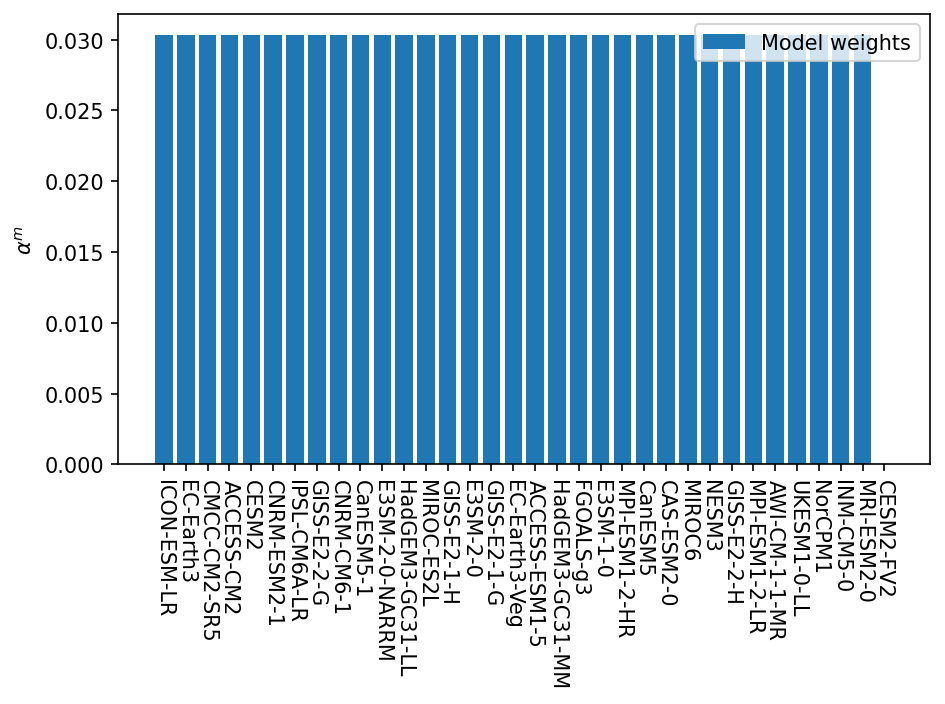

/tmp/ipykernel_11011/3144833690.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)


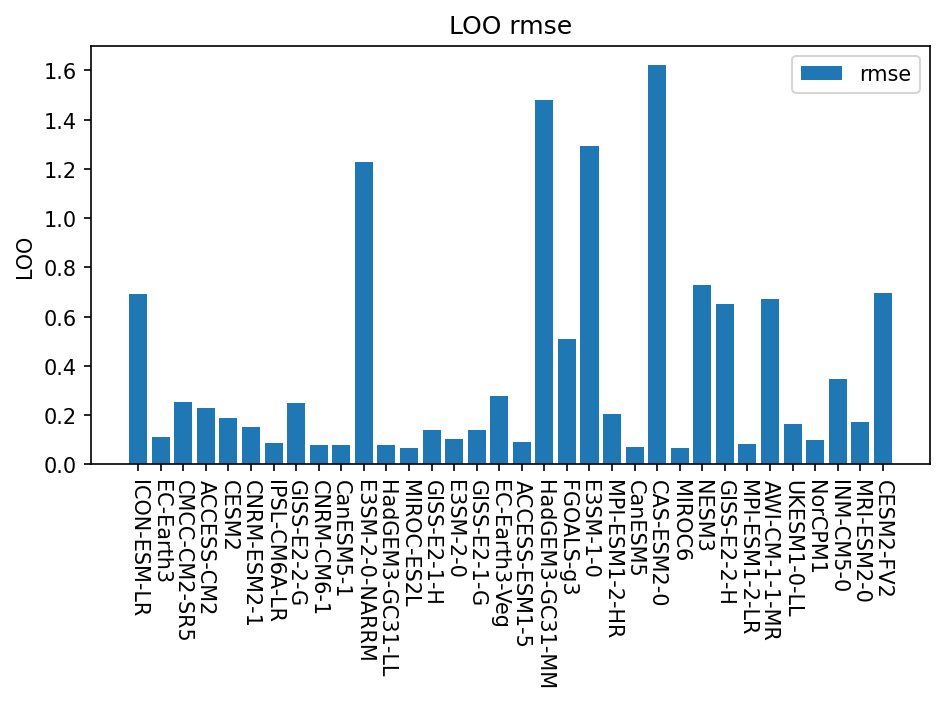

In [96]:
W_rrr, rmse_mean_rrr, training_loss_rrr, weights_rrr = leave_one_out_procedure(x,y,vars,\
                                                                            lon_size,lat_size, notnan_idx,time_period=33,\
                                                                            method='rrr',rank=10,lambda_=lambda_tmp,mu_=mu_tmp,\
                                                                            lr=1e-5,nb_gradient_iterations=50,verbose=True)

In [97]:
W_robust, rmse_mean_robust, training_loss_robust, weights_robust = leave_one_out_procedure(x,y,vars,\
                                                                                    lon_size,lat_size, notnan_idx,time_period=33,\
                                                                                    method='robust',rank=None,lambda_=lambda_tmp,mu_=mu_tmp,\
                                                                                    lr=1e-5,nb_gradient_iterations=50,verbose=True)

Iteration:  0  Loss:  68391.625
Iteration:  1  Loss:  54988.421875
Iteration:  2  Loss:  52712.97265625
Iteration:  3  Loss:  49781.0859375
Iteration:  4  Loss:  46349.01171875
Iteration:  5  Loss:  43870.28125
Iteration:  6  Loss:  41659.84765625
Iteration:  7  Loss:  39652.24609375
Iteration:  8  Loss:  37642.99609375
Iteration:  9  Loss:  35850.19140625
Iteration:  10  Loss:  34154.91796875
Iteration:  11  Loss:  32612.830078125
Iteration:  12  Loss:  31237.759765625
Iteration:  13  Loss:  30077.927734375
Iteration:  14  Loss:  29147.384765625
Iteration:  15  Loss:  28404.099609375
Iteration:  16  Loss:  27783.14453125
Iteration:  17  Loss:  27237.0
Iteration:  18  Loss:  26740.0
Iteration:  19  Loss:  26280.2578125
Iteration:  20  Loss:  25852.990234375
Iteration:  21  Loss:  25456.802734375
Iteration:  22  Loss:  25091.642578125
Iteration:  23  Loss:  24757.41796875
Iteration:  24  Loss:  24453.236328125
Iteration:  25  Loss:  24177.240234375
Iteration:  26  Loss:  23926.884765625

/tmp/ipykernel_11011/513617020.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = torch.nn.functional.softmax(alpha)


RMSE (mean) on model  ICON-ESM-LR  :  0.5545355705576641
Iteration:  0  Loss:  68391.625
Iteration:  1  Loss:  54988.421875
Iteration:  2  Loss:  52712.97265625
Iteration:  3  Loss:  49781.0859375
Iteration:  4  Loss:  46349.01171875
Iteration:  5  Loss:  43870.28125
Iteration:  6  Loss:  41659.84765625
Iteration:  7  Loss:  39652.2578125
Iteration:  8  Loss:  37643.046875
Iteration:  9  Loss:  35850.4375
Iteration:  10  Loss:  34156.19921875
Iteration:  11  Loss:  32618.71484375
Iteration:  12  Loss:  31259.96484375
Iteration:  13  Loss:  30137.984375
Iteration:  14  Loss:  29261.23046875
Iteration:  15  Loss:  28570.732421875
Iteration:  16  Loss:  27992.876953125
Iteration:  17  Loss:  27479.939453125
Iteration:  18  Loss:  27009.90625
Iteration:  19  Loss:  26574.58203125
Iteration:  20  Loss:  26171.01171875
Iteration:  21  Loss:  25797.765625
Iteration:  22  Loss:  25453.72265625
Iteration:  23  Loss:  25137.685546875
Iteration:  24  Loss:  24848.15234375
Iteration:  25  Loss:  2

KeyboardInterrupt: 

In [ ]:
# W_robust_rrr, rmse_mean_robust_rrr, training_loss_robust_rrr, weights_robust_rrr = leave_one_out_procedure(x,y,vars,\
#                                                                                     lon_size,lat_size, notnan_idx,time_period=33,\
#                                                                                     method='robust',rank=10,lambda_=lambda_tmp,mu_=mu_tmp,\
#                                                                                     lr=1e-5,nb_gradient_iterations=20,verbose=True)

In [ ]:
################### Ridge regresssion ########################
# compute the ridge loo
rmse_ridge_tmp =  np.array(list(rmse_mean_ridge.values()))

# worst loo Ridge
worst_loo_ridge = np.max(rmse_ridge_tmp)
mean_loo_ridge = np.mean(rmse_ridge_tmp)


# quantile 95, 90, 75
q_loo_95_ridge = np.quantile(rmse_ridge_tmp, 0.95)
q_loo_90_ridge = np.quantile(rmse_ridge_tmp, 0.90)
q_loo_75_ridge = np.quantile(rmse_ridge_tmp, 0.75)
q_loo_50_ridge = np.quantile(rmse_ridge_tmp, 0.5)


######################## compute the ridge rrr ######################
rmse_rrr_tmp =  np.array(list(rmse_mean_rrr.values()))

# worst loo Ridge
worst_loo_rrr = np.max(rmse_rrr_tmp)
mean_loo_rrr = np.mean(rmse_rrr_tmp)


# quantile 95, 90, 75
q_loo_95_rrr = np.quantile(rmse_rrr_tmp, 0.95)
q_loo_90_rrr = np.quantile(rmse_rrr_tmp, 0.90)
q_loo_75_rrr = np.quantile(rmse_rrr_tmp, 0.75)
q_loo_50_rrr = np.quantile(rmse_rrr_tmp, 0.5)


######################## compute the robust regression ######################
rmse_robust_tmp =  np.array(list(rmse_mean_robust.values()))

# worst loo Ridge
worst_loo_robust = np.max(rmse_robust_tmp)
mean_loo_robust = np.mean(rmse_robust_tmp)


# quantile 95, 90, 75
q_loo_95_robust = np.quantile(rmse_robust_tmp, 0.95)
q_loo_90_robust = np.quantile(rmse_robust_tmp, 0.90)
q_loo_75_robust = np.quantile(rmse_robust_tmp, 0.75)
q_loo_50_robust = np.quantile(rmse_robust_tmp, 0.5)

######################## compute the robust regression with low rank constraint ######################
rmse_robust_rrr =  np.array(list(rmse_mean_robust_rrr.values()))

# worst loo Ridge
worst_loo_robust_rrr = np.max(rmse_robust_rrr)
mean_loo_robust_rrr = np.mean(rmse_robust_rrr)


# quantile 95, 90, 75
q_loo_95_robust_rrr = np.quantile(rmse_robust_rrr, 0.95)
q_loo_90_robust_rrr = np.quantile(rmse_robust_rrr, 0.90)
q_loo_75_robust_rrr = np.quantile(rmse_robust_rrr, 0.75)
q_loo_50_robust_rrr = np.quantile(rmse_robust_rrr, 0.5)


print("======= Statistics ========")
print("\n")
print("          Ridge   RR-Lr   Robust  Robust-Lr")
print("Worst:    {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(worst_loo_ridge,worst_loo_rrr,worst_loo_robust, worst_loo_robust_rrr))
print("0.95:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_95_ridge,q_loo_95_rrr,q_loo_95_robust, q_loo_95_robust_rrr))
print("0.90:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_90_ridge,q_loo_90_rrr,q_loo_90_robust, q_loo_90_robust_rrr))
print("0.75:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_75_ridge,q_loo_75_rrr,q_loo_75_robust, q_loo_75_robust_rrr))
print("Median:   {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_50_ridge,q_loo_50_rrr,q_loo_50_robust, q_loo_50_robust_rrr))
print("Mean:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(mean_loo_ridge,mean_loo_rrr,mean_loo_robust, mean_loo_robust_rrr))

#### Display the weights

In [ ]:
weights_robust_tmp = torch.zeros(len(x.keys()))
weights_robust_lr_tmp = torch.zeros(len(x.keys()))

for idx_m, m in enumerate(x.keys()):
    weights_robust_tmp +=  torch.tensor(list(weights_robust[m].values()))
    weights_robust_lr_tmp += torch.tensor(list(weights_robust_rrr[m].values()))

weights_robust_tmp = weights_robust_tmp / (len(x.keys()))
weights_robust_lr_tmp = weights_robust_lr_tmp / (len(x.keys()))

In [ ]:
plt.close("all")

################# plot the rmse #################
fig, ax = plt.subplots()
ax.bar(list(x.keys()), weights_robust_tmp,label='Model weights')
ax.set_ylabel(r'$\alpha^m$')
ax.legend()
ax.set_xticklabels(list(x.keys()), rotation=-90)
plt.tight_layout()
# plt.savefig("results/weights_"+str(mu_)+"_"+str(lambda_)+".eps", dpi=150)
plt.show()

fig, ax = plt.subplots()
ax.bar(list(x.keys()), weights_robust_lr_tmp,label='Model weights')
ax.set_ylabel(r'$\alpha^m$')
ax.legend()
ax.set_xticklabels(list(x.keys()), rotation=-90)
plt.tight_layout()
# plt.savefig("results/weights_"+str(mu_)+"_"+str(lambda_)+".eps", dpi=150)
plt.show()

## Compute the matrix W as the mean across the LOO

In [ ]:
# define rank
r = 10

W_robust_mean = torch.from_numpy(np.mean(np.array(list(W_robust.values())),axis=0))
W_robust_mean = low_rank_projection(W_robust_mean,rank=10)

In [ ]:
# SVD decomposition

U, S, V = torch.linalg.svd(W_robust_mean, full_matrices=True)

In [ ]:
S

In [ ]:
# projection 
U, S, V = torch.pca_lowrank(W_robust_mean, q=r)
proj = W_robust_mean @ V
# proj = S

In [ ]:
proj.shape

In [ ]:
# proj[nan_idx,:] = float('nan') 
# proj_to_plot = proj.detach().numpy().reshape(lat_size,lon_size)

# plt.close("all")
# fig0 = plt.figure(figsize=(24,16))   

# ax0 = fig0.add_subplot(1, 1, 1)        
# ax0.set_title(r'C', size=7,pad=3.0)
# im0 = ax0.pcolormesh(lon_grid,lat_grid,proj_to_plot,vmin=-0.0,vmax=0.1)
# plt.colorbar(im0, ax=ax0, shrink=0.3)
# ax0.set_xlabel(r'x', size=7)
# ax0.set_ylabel(r'y', size=7)

# plt.show()

In [ ]:
# display all projections 
plt.close("all")
fig0 = plt.figure(figsize=(24,16))   

for k in range(1):

    proj[:,k][nan_idx] = float('nan') 
    proj_to_plot = proj[:,k].detach().numpy().reshape(lat_size,lon_size)

    ax0 = fig0.add_subplot(int(r/2), int(r/2), k+1)        
    ax0.set_title(r'C', size=7,pad=3.0)
    im0 = ax0.pcolormesh(lon_grid,lat_grid,proj_to_plot,vmin=-0.5,vmax=1.0)
    plt.colorbar(im0, ax=ax0, shrink=0.3)
    ax0.set_xlabel(r'x', size=7)
    ax0.set_ylabel(r'y', size=7)

plt.show()

# Train the model using Pytorch autograd

In [ ]:
def train_robust_model(models,x,y,lon_size,lat_size,lambda_=1.0,mu_=1.0,nbEpochs=100,verbose=True):
    """
    Learn parameter β such that β = argmin( log Σ_m exp(||y_m - X_m^T β||^2) ).

    Args:
        - x,y : location, observation 
        - lon_size, lat_size: longitude and latitude grid size (Int)
        - models: (sub)list of models (list)
        - mu_: softmax coefficient (float)
        - nbepochs: number of optimization steps (Int)
        - verbose: display logs (bool)
    """

    # define variable beta
    w = torch.zeros(lon_size*lat_size,lon_size*lat_size).to(torch.float64)
    w.requires_grad_(True)  

    # define optimizer
    optimizer = torch.optim.SGD([w],lr=1e-5)

    # stopping criterion
    criteria = torch.tensor(0.0)
    criteria_tmp = torch.tensor(1.0) 
    epoch = 0
    training_loss = torch.zeros(nbEpochs)
    
            
    # --- optimization loop ---                
    while (torch.abs(criteria - criteria_tmp) >= 1e-6) & (epoch < nbEpochs):

        # update criteria
        criteria_tmp = criteria.clone()
                      
        optimizer.zero_grad()
        
        # compute loss functon to check convergence 
        res = torch.zeros(len(models))

        for idx_m, m in enumerate(models):

            # compute residuals
            res[idx_m] = torch.mean(torch.norm(y[m][:,:,notnan_idx] -x[m][:,:,notnan_idx] @ w[notnan_idx,:][:,notnan_idx], p='fro',dim=(1,2))**2)
    
        obj = mu_*torch.logsumexp((1/mu_)* res,0)
        obj += lambda_*torch.norm(w,p='fro')**2
                    
        #define loss function
        loss = obj

        # set the training loss
        training_loss[epoch] = loss.detach().item()
                    
        # Use autograd to compute the backward pass. 
        loss.backward()               
        
        # take a step into optimal direction of parameters minimizing loss
        optimizer.step() 


        if(verbose==True):
            if(epoch % 2 == 0):
                print('Epoch ', epoch, 
                        ', loss=', training_loss[epoch].detach().item()
                        )
        criteria = loss
        epoch +=1
    
    plt.figure()
    plt.plot(range(nbEpochs),training_loss)
    plt.title('Training loss')
    plt.ylabel('Loss')
    plt.xlabel('iterations')
    plt.show()


    ############ HERE ####################
    # # compute the alphas of the robust model
    # M = len(x.keys())
    # alpha = torch.zeros(M)
    # res = torch.zeros(M,33)
    
    # # compute the training loss for each model
    # model_loss = torch.zeros(M)
    
    # for idx_m,m in enumerate(x.keys()):
    #     for idx_i, i in enumerate(x[m].keys()):
    #         res[idx_m,:] += (y[m][i] - torch.matmul(x[m][i],beta))**2/vars[m]
            
    #     res[idx_m,:] = res[idx_m,:]/len(x[m].keys())
    #     alpha[idx_m] = (1/mu_)*torch.mean(res[idx_m,:],axis=0)
    #     model_loss[idx_m] = torch.mean(res[idx_m,:])
    
    # alpha = torch.nn.functional.softmax(alpha)
    
    return w

In [ ]:
W = train_robust_model(training_models,x,y,lon_size,lat_size,lambda_=100.0,mu_=1000.0,nbEpochs=300,verbose=True)

In [ ]:
W

In [ ]:
y_pred = torch.ones_like(x_test).to(torch.float64)
y_pred[:,nan_idx] = float('nan')
y_pred[:,notnan_idx] = x_test[:,notnan_idx].to(torch.float64) @ W[notnan_idx,:][:,notnan_idx].to(torch.float64)

y_target = y_test[:time_period,:]
y_target_pred = y_pred[:time_period,:]


# display Y map for a given model m0
time_idx = 20
y_target[:,nan_idx] = float('nan')
y_target_pred[:,nan_idx] = float('nan')

y_to_plot_target = y_target[time_idx,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred = y_target_pred[time_idx,:].detach().numpy().reshape(lat_size,lon_size)


plt.close('all')
fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(2, 2, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax0 = fig0.add_subplot(2, 2, 2)        
ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

plt.show()

In [ ]:
torch.nanmean((y_target - y_target_pred)**2)

In [ ]:
from matplotlib import animation

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()


plt.close('all')
fig0 = plt.figure()

ax0 = fig0.add_subplot(1, 2, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax1 = fig0.add_subplot(1, 2, 2)        
ax1.set_title(r'Robust reduced rank regression ', size=7,pad=3.0)
ax1.set_xlabel(r'x', size=7)
ax1.set_ylabel(r'y', size=7)

y_to_plot_target = y_target[0,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred = y_target_pred[0,:].detach().numpy().reshape(lat_size,lon_size)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)


def animate_maps(i):

    y_to_plot_target = y_target[i,:].detach().numpy().reshape(lat_size,lon_size)
    y_to_plot_pred = y_target_pred[i,:].detach().numpy().reshape(lat_size,lon_size)

    im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
    im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)
    
plt.colorbar(im0, ax=ax0, shrink=0.3)
plt.colorbar(im1, ax=ax1, shrink=0.3)
plt.tight_layout()
animation.FuncAnimation(fig0, animate_maps, frames=time_period)